In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
basedir = "/pscratch/sd/h/hebina/AbacusLBG/"
import sys, os
from astropy.table import Table, vstack
from astropy.io import fits

for subdir in ["",'ibis_tertiary44/LAE_auto_v2']:
    sys.path.append(basedir+subdir)
from misc import *
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import json
from scipy.special     import erfc

sys.path.append('..')
from mc_forecast import mc_forecast
from forecast_utils import *

sys.path.append('/pscratch/sd/h/hebina/AbacusLBG')
from calc_wt import *
from calc_wx import *
from calc_xi import *
from wtheta_xi import *


In [4]:
from matplotlib.pyplot import rc
rc('mathtext', **{'fontset':'cm'})
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"


In [5]:
m_bands = ['M411','M438','M464','M490','M517']
band_z = {
    'M411':[2.26,2.56],
    'M438':[2.47,2.77],
    'M464':[2.68,2.98],
    'M490':[2.89,3.2],
    'M517':[3.1,3.41]
}
band_chimid = {'M411': 3945.5839397567484, 'M438': 4112.149560017418, 'M464': 4265.362496255113, 'M490': 4409.927293886262, 'M517': 4540.894419987146}


In [6]:
cosmo = get_cosmo_P18()
h = cosmo.h()

In [7]:
rbins = np.geomspace(0.4,45,9)[1:]
RwR = np.sqrt(rbins[1:]*rbins[:-1])


In [8]:
fint_list = np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/pessimistic_bright.txt')
fint_list += np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/optimistic_bright.txt')
fint_list /= 2

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/wR_v4/lae_5bins_bright.json'
data = json.load(open(fn,'r'))

datwt_array = []
for j, band in enumerate(m_bands):
    fint = fint_list[j]    
    datwt_array.append(np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2)
datwt_array = np.array(datwt_array)

In [9]:
fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/clustering_cat_v4_bright.fits"
# fn = "/global/cfs/cdirs/desi/users/raichoor/laelbg/ibis/analysis/daily-tmp/ibis-xmm-ar-djs-he-rr.fits"
d = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d['RA'],d['DEC'],ra0,dec0)<radius
d = d[coord_cut]

fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/redshift_cat_v4_bright.fits"
# fn = "/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto/ibis-xmm-ar-djs-he-rr.fits"
d_spec = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d_spec['RA'],d_spec['DEC'],ra0,dec0)<radius
d_spec = d_spec[coord_cut]

In [10]:
use_mask = True

# $\chi^2$ fits

In [19]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0,12.25,12.5]
alph_list = [.33,.5,.66]#,1.]
sigm_list = [.33,.5,.66]#,1.]
kapp_list = [1]
plat_list = [5,10]

chi2_arr = []
hod_arr = []
for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          # hod_params = {'logM_cut':11.75,'logM1':12.45,'sigma':0.66,'kappa':1.00,'alpha':1.0}
          hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph}      
          forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                   band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                   m_bands=['M411','M438'],zbox=2.5)
          assert forecast.check_hod_exists()
          # forecast.make_cat(overwrite=False)
          # forecast.compute_wR(overwrite=False)
          c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[:2])
          hod_arr.append(hod_params)
          chi2_arr.append(c2)
#           plt.plot(RwR,RwR*tmp1,'o-')
#           plt.plot(RwR,RwR*tmp2,'k.--')
# plt.xscale('log')
# plt.show()       


7.230180430562331
{'logM_cut': 11.25, 'logM1': 12.25, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.5}


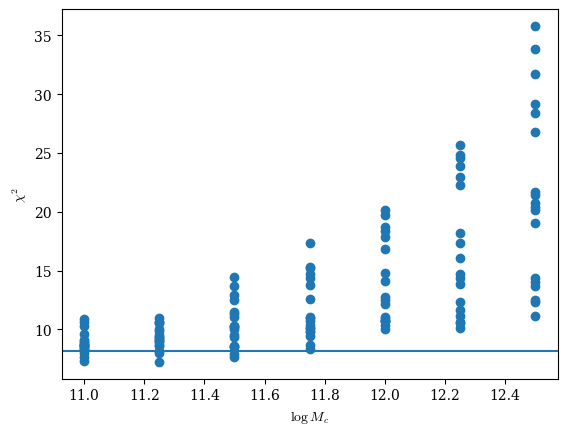

In [20]:
plt.scatter([ss['logM_cut'] for ss in hod_arr],chi2_arr)
print(np.min(chi2_arr))
print(hod_arr[np.argmin(chi2_arr)])
plt.axhline(8.18)
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$\log M_c$')
# plt.ylim(2.9,3.0)
# chi2(k=7)	8.18	9.80	12.02	14.07	14.34	18.48	21.85	24.32	30.96
plt.show()

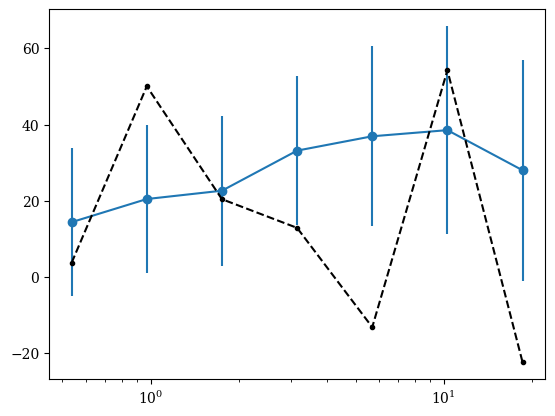

In [23]:
hod_z1 = hod_arr[np.argmin(chi2_arr)]
chi2_z1 = np.min(chi2_arr)
forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                       band_z['M411'][0], band_z['M517'][1], hod_z1, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                       m_bands=['M411','M438'],zbox=2.5)
c2, dd_z1, ss_z1, cov_z1 = forecast.chi2_wR(datwt_array[:2])
plt.errorbar(RwR,RwR*dd_z1,fmt='o-',yerr=RwR*np.sqrt(np.diag(cov_z1)))
plt.errorbar(RwR,RwR*ss_z1,fmt='k.--')
plt.xscale('log')
plt.show()       
# print(np.einsum(dd-ss)


In [14]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0,12.25,12.5]
alph_list = [.33,.5,.66]#,1.]
sigm_list = [.33,.5,.66]#,1.]
kapp_list = [1]
plat_list = [5,10]
chi2_arr = []
hod_arr = []
for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          # hod_params = {'logM_cut':11.75,'logM1':12.45,'sigma':0.66,'kappa':1.00,'alpha':1.0}
          hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph}      
          forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                   band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                   m_bands=['M464','M490','M517'],zbox=3.0)
          assert forecast.check_hod_exists()
          # forecast.make_cat(overwrite=False)
          # forecast.compute_wR(overwrite=False)
          c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[2:])
          hod_arr.append(hod_params)
          chi2_arr.append(c2)
#           plt.plot(RwR,RwR*tmp1,'o-')
#           plt.plot(RwR,RwR*tmp2,'k.--')
# plt.xscale('log')
# plt.show()       


6.646914424863334
{'logM_cut': 11.75, 'logM1': 12.448970004336019, 'sigma': 0.66, 'kappa': 1, 'alpha': 0.33}


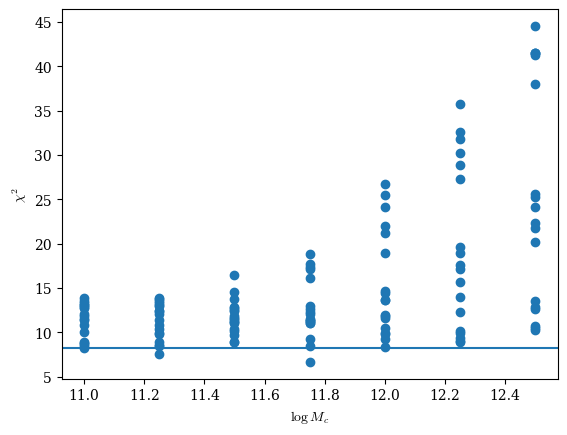

In [15]:
plt.scatter([ss['logM_cut'] for ss in hod_arr],chi2_arr)
print(np.min(chi2_arr))
print(hod_arr[np.argmin(chi2_arr)])
plt.axhline(8.18)
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$\log M_c$')

plt.show()

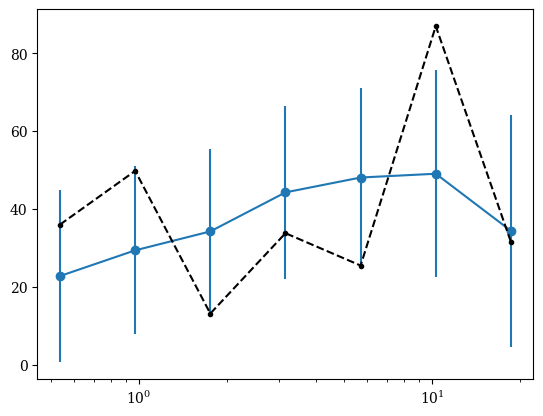

In [16]:
hod_z2 = hod_arr[np.argmin(chi2_arr)]
chi2_z2 = np.min(chi2_arr)
forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                       band_z['M411'][0], band_z['M517'][1], hod_z2, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                       m_bands=['M464','M490','M517'],zbox=3.0)
c2, dd_z2, ss_z2, cov_z2 = forecast.chi2_wR(datwt_array[2:])
plt.errorbar(RwR,RwR*dd_z2,fmt='o-',yerr=RwR*np.sqrt(np.diag(cov_z2)))
plt.errorbar(RwR,RwR*ss_z2,fmt='k.--')
plt.xscale('log')
plt.show()       
# print(np.einsum(dd-ss)


In [17]:
bestfit_dict = {'z1':{'z':2.5,
                      'data':ss_z1.tolist(),
                      'sim':dd_z1.tolist(),
                      'cov':cov_z1.tolist(),
                      'hod':hod_z1,
                      'chi2':chi2_z1,
                     },
                'z2':{'z':3.0,
                      'data':ss_z2.tolist(),
                      'sim':dd_z2.tolist(),
                      'cov':cov_z2.tolist(),
                      'hod':hod_z2,
                      'chi2':chi2_z2,
                     },
                'R':RwR.tolist(),
                'rbins':rbins.tolist(),
               }
import json
with open('bestfit.json', 'w') as fp:
    json.dump(bestfit_dict, fp)


In [18]:
def wt_band_from_r0(r0):
    gamma = 1.8
    rr = np.geomspace(0.1,50)
    wt_acc_band = []
    for iband in range(5):
        if iband<2: zmid = 3.0 #2.5
        else: zmid=3.0
    
        tmp  = json.load(open('../AbacusSummit_high_c000_ph100/z%.1f/ibis_tertiary44_bright_v4.2/logM_cut_11.25_logM1_12.25_sigma_0.33_kappa_1.00_alpha_0.33/configs.json'%zmid,'r'))
        
        # ax.plot(rr,rr*wp_true,label='truth')
        
        if iband<2: p_func = Spline(tmp['chi_vector'],np.array(tmp['dNdchi_band'][iband])/np.trapz(tmp['dNdchi_band'][iband],tmp['chi_vector']),ext='zeros')
        else: p_func = Spline(tmp['chi_vector'],np.array(tmp['dNdchi_band'][iband-2])/np.trapz(tmp['dNdchi_band'][iband-2],tmp['chi_vector']),ext='zeros')
        xi_func = Spline(rr,(r0/rr)**gamma,ext='zeros')
        theta = RwR * 180/np.pi / band_chimid[m_bands[iband]]
        wt_accurate = []    
        for tt in theta:
            wt_accurate.append(w_theta(tt*np.pi/180,p_func,xi_func,Npnt=750))
        wt_accurate = np.array(wt_accurate)
        wt_acc_band.append(wt_accurate)
    wt_acc_band = np.array(wt_acc_band)
    return wt_acc_band
power_dict = {}
for r0 in [2,3,4,5]:
    f2_dict = json.load(open('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/f2_bright.json','r'))
    # load bestfit HODs and use that to generate wp (with input wR (above)) 
    total_bf = json.load(open('bestfit.json','r'))
    
    wp_r0 = np.zeros((2,len(RwR))) # redshift, R 
    chi2_r0 = np.zeros((2))

    wt_acc_band = wt_band_from_r0(r0)
    for i, bf_dict in enumerate([total_bf]): # sample
        tmp_hod = bf_dict['z1']['hod']
        forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                               band_z['M411'][0], band_z['M517'][1], tmp_hod, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                               m_bands=['M411','M438'],zbox=2.5)
        c2, _, mm, _ = forecast.chi2_wR(wt_acc_band[:2])
        wp_r0[0] = mm
        chi2_r0[0] = c2
        
        tmp_hod = bf_dict['z2']['hod']
        forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                               band_z['M411'][0], band_z['M517'][1], tmp_hod, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                               m_bands=['M464','M490','M517'],zbox=3.0)
        c2, _, mm, _ = forecast.chi2_wR(wt_acc_band[2:])
        wp_r0[1] = mm
        chi2_r0[1] = c2
    power_dict['%d'%r0] = {'wp':wp_r0.tolist(),
                     'chi2':chi2_r0.tolist(),
                     }
    
import json
with open('powerlaw_xi.json', 'w') as fp:
    json.dump(power_dict, fp)



In [23]:
import scipy.stats as stats
import numpy as np
def chi2_to_two_sided_sigmas(chi2, dof):
    # Get the p-value from chi2 (upper tail)
    p_value = stats.chi2.sf(chi2, dof)

    # Convert to equivalent two-sided Z-score
    sigmas = stats.norm.isf(p_value / 2)

    return sigmas
# two_sided_sigmas_to_chi2(1,40), two_sided_sigmas_to_chi2(2,40)
chi2_to_two_sided_sigmas(43.7,40), chi2_to_two_sided_sigmas(56.264617374339316,40)


(1.0002939683633372, 2.000000000000005)

In [ ]:
    chi2_to_two_sided_sigmas(8.18,7), chi2_to_two_sided_sigmas(14.34,7)


In [37]:
total_bf = json.load(open('bestfit.json','r'))
bright_bf = json.load(open('../ibis_tertiary44_bright/bestfit.json','r'))
for i in range(2):
    outstr = ''
    dtmp = total_bf['z%d'%(i+1)]['hod']
    for key in dtmp.keys(): outstr += '%.2f & '%dtmp[key]
    print(outstr)
    outstr = ''
    dtmp = bright_bf['z%d'%(i+1)]['hod']
    for key in dtmp.keys(): outstr += '%.2f & '%dtmp[key]
    print(outstr)

    
for i in range(2):
    print('%.2f ($%.2f\sigma$)'%(total_bf['z%d'%(i+1)]['chi2'],chi2_to_two_sided_sigmas(total_bf['z%d'%(i+1)]['chi2'],7)))
    print('%.2f ($%.2f\sigma$)'%(bright_bf['z%d'%(i+1)]['chi2'],chi2_to_two_sided_sigmas(bright_bf['z%d'%(i+1)]['chi2'],7)))


11.00 & 12.00 & 0.66 & 1.00 & 0.50 & 
11.00 & 11.70 & 0.66 & 1.00 & 0.66 & 
11.25 & 11.95 & 0.50 & 1.00 & 0.66 & 
11.75 & 12.75 & 0.50 & 1.00 & 0.66 & 
2.02 ($0.05\sigma$)
6.20 ($0.65\sigma$)
8.27 ($1.02\sigma$)
7.71 ($0.92\sigma$)


In [22]:
chi2_to_two_sided_sigmas(2.02,7), chi2_to_two_sided_sigmas(8.27,7), 


(0.05175348680831493, 1.0165052731340687)

In [52]:
chi2_to_two_sided_sigmas(2.870130844320968,7),chi2_to_two_sided_sigmas(4.079544662742021,7)

(0.129767232237465, 0.291627821188064)

In [53]:
chi2_to_two_sided_sigmas(4.117314785573226,7),chi2_to_two_sided_sigmas(4.90418422455023,7)

(0.2973880460181899, 0.42387781214988174)

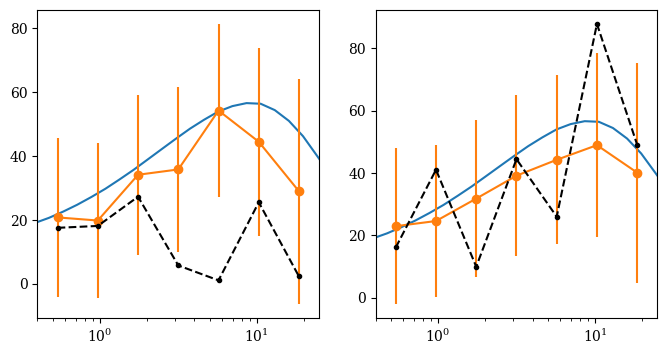

In [20]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_c000_ph100_z2.5_r.json'
lae = json.load(open(fn,"r"))

hod_params = hod_z1
rr = lae['R']
for i,samp in enumerate(lae['mocks']):
  tmp = True
  for pp in hod_params.keys():
      ppidx = lae['hodkeys'].index(pp)
      tmp &= hod_params[pp]==samp['hod'][ppidx]
  if tmp: break
wp_true = np.array(samp['wp'])

ax.plot(rr,wp_true*rr)

forecast = mc_forecast.initialize('ibis_tertiary44_clustering',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                       band_z['M411'][0], band_z['M517'][1], hod_z1, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                       m_bands=['M411','M438'],zbox=2.5)
c2, dd_z1, ss_z1, cov_z1 = forecast.chi2_wR(datwt_array[:2])
ax.errorbar(RwR,RwR*dd_z1,fmt='o-',yerr=RwR*np.sqrt(np.diag(cov_z1)))
ax.errorbar(RwR,RwR*ss_z1,fmt='k.--')

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_c000_ph100_z3.0_r.json'
lae = json.load(open(fn,"r"))

ax = axs[1]

hod_params = hod_z2
rr = lae['R']
for i,samp in enumerate(lae['mocks']):
  tmp = True
  for pp in hod_params.keys():
      ppidx = lae['hodkeys'].index(pp)
      tmp &= hod_params[pp]==samp['hod'][ppidx]
  if tmp: break
wp_true = np.array(samp['wp'])

ax.plot(rr,wp_true*rr)

forecast = mc_forecast.initialize('ibis_tertiary44_clustering',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                       band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                       m_bands=['M464','M490','M517'],zbox=3.0)
c2, dd_z2, ss_z2, cov_z2 = forecast.chi2_wR(datwt_array[2:])
ax.errorbar(RwR,RwR*dd_z2,fmt='o-',yerr=RwR*np.sqrt(np.diag(cov_z1)))
ax.errorbar(RwR,RwR*ss_z2,fmt='k.--')

for i, ax in enumerate(axs):
    ax.set_xscale('log')
    ax.set_xlim(.4,25)
plt.show()